In [51]:
# Import models and utility functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


# ignore warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



# EDA

In [52]:
# import data
file = '/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file)
print(df.columns)
df = df.rename(columns={'oldbalanceOrg': 'Old_Balance_Orig',
                        'newbalanceOrig': 'New_Balance_Orig',
                        'oldbalanceDest': 'Old_Balance_Dest',
                        'newbalanceDest': 'New_Balance_Dest',
                        'nameOrig': 'Name_Orig',
                        'nameDest': 'Name_Dest'})
print(df.head())
print(df.info())

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
   step      type    amount    Name_Orig  Old_Balance_Orig  New_Balance_Orig  \
0     1   PAYMENT   9839.64  C1231006815          170136.0         160296.36   
1     1   PAYMENT   1864.28  C1666544295           21249.0          19384.72   
2     1  TRANSFER    181.00  C1305486145             181.0              0.00   
3     1  CASH_OUT    181.00   C840083671             181.0              0.00   
4     1   PAYMENT  11668.14  C2048537720           41554.0          29885.86   

     Name_Dest  Old_Balance_Dest  New_Balance_Dest  isFraud  isFlaggedFraud  
0  M1979787155               0.0               0.0        0               0  
1  M2044282225               0.0               0.0        0               0  
2   C553264065               0.0               0.0        1               0  
3    C3899701

In [53]:
# EDA
print('\n The types of fraudulent transactions are {}'.format(
    list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))
#
print(df.shape)
#df = df.loc[(df.isFraud!=1)&(df.amount!=0)]

print(df.shape)


dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\n No.fraudulent in TRANSFERs = {}'.
      format(len(dfFraudTransfer)))
# The Number of

print('\n No.fraudulent in CASH_OUTs = {}'.
      format(len(dfFraudCashout)))

# data import and cleaning
X = df.loc[(df.type == 'TRANSFER')]
#X = df.loc[(df.type == 'CASH_OUT')]
y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['Name_Orig', 'Name_Dest', 'isFlaggedFraud', 'type'], axis=1)
print(X.head())


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']
(6362620, 11)
(6362620, 11)

 No.fraudulent in TRANSFERs = 4097

 No.fraudulent in CASH_OUTs = 4116
    step     amount  Old_Balance_Orig  New_Balance_Orig  Old_Balance_Dest  \
2      1     181.00            181.00               0.0              0.00   
19     1  215310.30            705.00               0.0          22425.00   
24     1  311685.89          10835.00               0.0           6267.00   
58     1   62610.80          79114.00           16503.2            517.00   
78     1   42712.39          10363.39               0.0          57901.66   

    New_Balance_Dest  
2               0.00  
19              0.00  
24        2719172.89  
58           8383.29  
78          24044.18  


In [54]:
print('Number of duplicates are : ', df.duplicated().sum())

Number of duplicates are :  0


In [55]:
df.isnull().sum()

step                0
type                0
amount              0
Name_Orig           0
Old_Balance_Orig    0
New_Balance_Orig    0
Name_Dest           0
Old_Balance_Dest    0
New_Balance_Dest    0
isFraud             0
isFlaggedFraud      0
dtype: int64

In [56]:
import plotly.express as px
type = df["type"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(df, values=quantity, names=transactions,width=500,height=500, title="Distribution of Transaction Type",
                color_discrete_sequence=px.colors.sequential.RdBu)
figure.show()

In [57]:
import plotly.express as px

type_counts = df['type'].value_counts()

# Create a bar plot using Plotly Express
fig = px.bar(x=type_counts.index, y=type_counts.values, labels={'x': 'Transaction Type', 'y': 'Count'}, title='Transaction Type Distribution')

# Show the plot
fig.show()

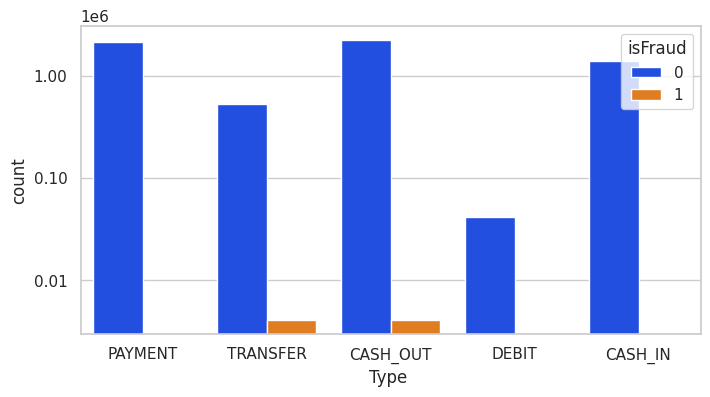

In [58]:
import matplotlib.ticker as mticker
def countplot_eda(df):
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize=(8, 4))
    counplot = sns.countplot(data=df, x='type', hue='isFraud',palette= "bright")
    counplot.set_xlabel('Type ')
    counplot.set_ylabel(f'count')
    counplot.set_yscale('log')
    counplot.yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.show()

countplot_eda(df)

*We can see, fraud transactions are done in TRANSFER and CASH_OUT transaction type.*

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [60]:
import plotly.graph_objects as go
fig=go.Figure(data=[go.Pie(labels=['Genuine','Fraud'], values=y_train.value_counts())])
fig.show()

In [61]:
print('size of X_train, X_test, y_train, y_test')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


size of X_train, X_test, y_train, y_test
(426327, 6) (106582, 6) (426327,) (106582,)


# Passive Agressive Classifier


In [62]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac_classifier = PassiveAggressiveClassifier()

# Train the model
pac_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pac_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of PAC result',acc)
from sklearn.metrics import confusion_matrix
print('confusion matrix of PAC with .2 random test data:')
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

accuracy of PAC result 0.9996153196599801
confusion matrix of PAC with .2 random test data:
[[105730     29]
 [    12    811]]


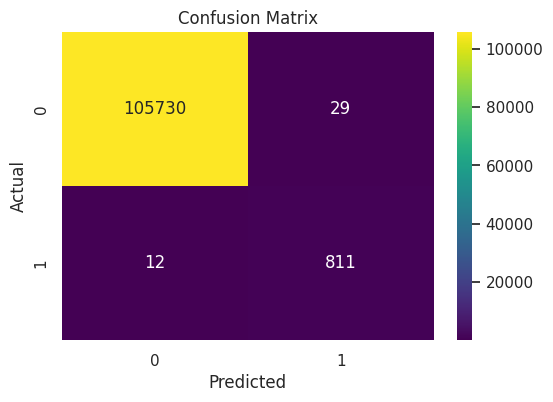

In [63]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decision Tree

In [64]:
dt = DecisionTreeClassifier(max_depth=5, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of decision tree result',acc)

accuracy of decision tree result 0.9997091441331557


In [65]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    105759
           1       0.99      0.97      0.98       823

    accuracy                           1.00    106582
   macro avg       1.00      0.98      0.99    106582
weighted avg       1.00      1.00      1.00    106582



In [66]:
#confusion matrix of decision tree result with .2 random test dataset
from sklearn.metrics import confusion_matrix
print('confusion matrix of decision tree with .2 random test data:')
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))


confusion matrix of decision tree with .2 random test data:
[[105753      6]
 [    25    798]]


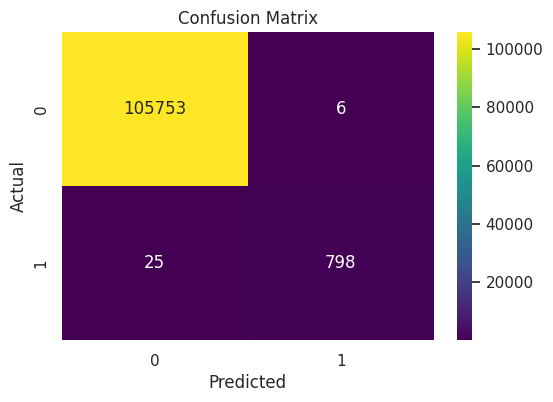

In [67]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Multinomial Naive Bayes

In [68]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_classifier = MultinomialNB()

# Train the model
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    105759
           1       0.37      1.00      0.54       823

    accuracy                           0.99    106582
   macro avg       0.69      0.99      0.77    106582
weighted avg       1.00      0.99      0.99    106582



# Gaussian Naives Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Train the classifier on the training data
gnb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gnb.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display additional metrics like precision, recall, and F1 score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105759
           1       0.60      0.58      0.59       823

    accuracy                           0.99    106582
   macro avg       0.80      0.79      0.80    106582
weighted avg       0.99      0.99      0.99    106582



# logistic regression

In [70]:
from sklearn import linear_model
from time import time
clf = linear_model.LogisticRegression()

clf.fit(X_train,y_train)

b = time()
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of Logistic regression result',acc)

a = time()
print('confusion matrix of logistic regression with .2 random test data:')
print(confusion_matrix(y_test, y_pred))

accuracy of Logistic regression result 0.9993526111350884
confusion matrix of logistic regression with .2 random test data:
[[105719     40]
 [    29    794]]


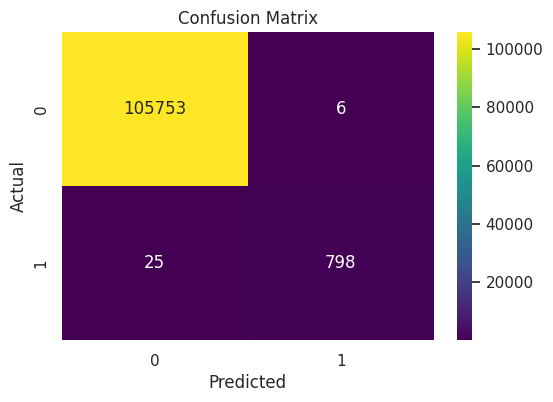

In [71]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    105759
           1       0.95      0.96      0.96       823

    accuracy                           1.00    106582
   macro avg       0.98      0.98      0.98    106582
weighted avg       1.00      1.00      1.00    106582



# L2 logistic regression

In [73]:
from sklearn import linear_model
from time import time
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)

clf.fit(X_train,y_train)

b = time()
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of logistic regression result',acc)

print('confusion matrix of L2 logistic regression with .2 random test data:')
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))


accuracy of logistic regression result 0.9993526111350884
confusion matrix of L2 logistic regression with .2 random test data:
[[105719     40]
 [    29    794]]


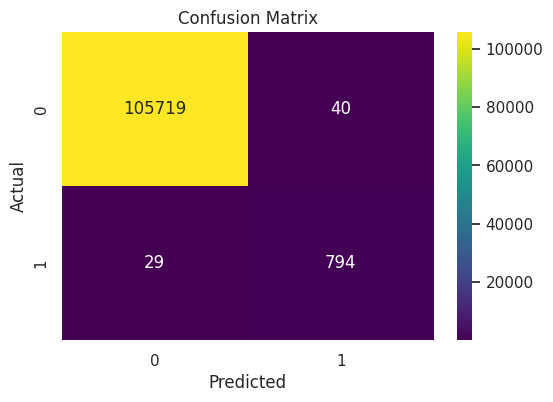

In [74]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [75]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    105759
           1       0.95      0.96      0.96       823

    accuracy                           1.00    106582
   macro avg       0.98      0.98      0.98    106582
weighted avg       1.00      1.00      1.00    106582



# SMOTE

In [76]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_train,y_train=sm.fit_resample(X_train,y_train)
fig=go.Figure(data=[go.Pie(labels=['Genuine','Fraud'],values=y_train.value_counts())])
fig.show()

In [77]:
over_sample = SMOTE(random_state=42)
X_train_sm, y_train_sm = over_sample.fit_resample(X_train,y_train)

In [78]:
print(sum(y_train_sm == 1), '- positive class')
print(sum(y_train_sm == 0), '- negative class')

423053 - positive class
423053 - negative class


# Logistic Regression

In [79]:
from sklearn import linear_model
from time import time
clf = linear_model.LogisticRegression()

clf.fit(X_train_sm, y_train_sm)


b = time()
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of Logistic regression result',acc)

a = time()
print('confusion matrix of logistic regression with .2 random test data:')
cm=confusion_matrix(y_test, y_pred)
print(cm)

accuracy of Logistic regression result 0.9850068491865418
confusion matrix of logistic regression with .2 random test data:
[[104165   1594]
 [     4    819]]


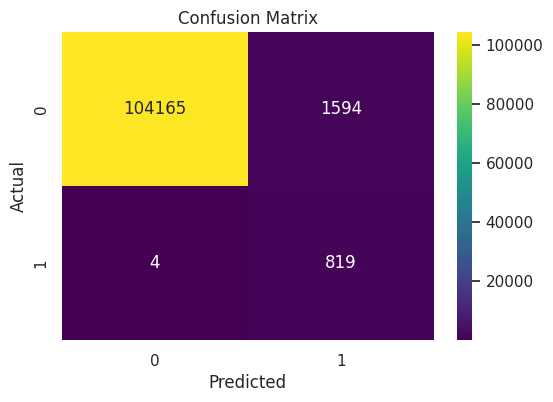

In [80]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [81]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    105759
           1       0.34      1.00      0.51       823

    accuracy                           0.99    106582
   macro avg       0.67      0.99      0.75    106582
weighted avg       0.99      0.99      0.99    106582



# Passive Agressive Classifier

In [82]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac_classifier = PassiveAggressiveClassifier()

# Train the model
pac_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pac_classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('accuracy of PAC result',acc)
from sklearn.metrics import confusion_matrix
print('confusion matrix of PAC with .2 random test data:')
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

accuracy of PAC result 0.9875494924096001
confusion matrix of PAC with .2 random test data:
[[104439   1320]
 [     7    816]]


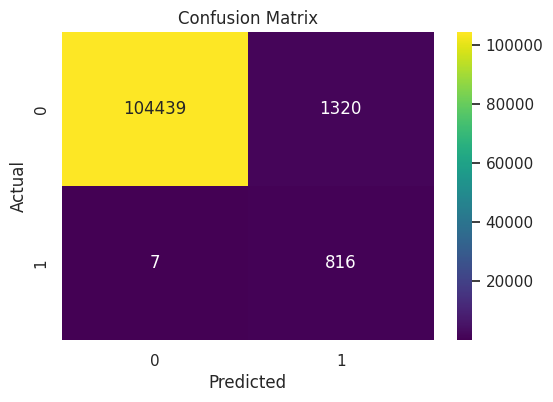

In [83]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    105759
           1       0.38      0.99      0.55       823

    accuracy                           0.99    106582
   macro avg       0.69      0.99      0.77    106582
weighted avg       1.00      0.99      0.99    106582

